<a href="https://colab.research.google.com/github/EdmilsonEMAndrade/Covid19-PortoAlegre/blob/master/PortoAlegreCovid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
#@title Análise a partir dos 500 casos confirmados de Covid-19 em Porto Alegre

#Inicializando

In [79]:
import pandas as pd  #bibioteca responsável para o tratamento e limpeza dos dados
import numpy as np
import matplotlib.pyplot as plt  #biblioteca utilizada para plotar os gráficos
import seaborn as sn 
from google.colab import files
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.model_selection import train_test_split
import sklearn
from datetime import timedelta
from erroFuncoes import  erroMedio, erroMedioMediano, erroMedioQuadratico
from graficoBarras import add_value_labels
from newEmptyCSV import *

In [80]:
#@title Carregando os dados 
dados_originais = pd.read_csv("/content/PortoAlegre_Covid.csv")
#@markdown ##### Gernado uma cópia
dados = dados_originais.copy()
#Conferter os dados da Data para o tipo Date
dados['Data'] = pd.to_datetime(dados.Data)

# Apresentação

In [81]:
#@title Tabela Inicial
dados

,Data,Confirmados,EmAnalise,Negativos,Obitos,Recuperados,inconclusivos,UTIConfirmado
0,2020-05-04,505,402,1422,16,303,2,36
1,2020-05-05,511,333,1452,17,327,2,30
2,2020-05-06,519,281,1494,17,343,2,38
3,2020-05-07,562,318,1553,17,367,2,39
4,2020-05-08,582,361,1602,17,374,2,40
...,...,...,...,...,...,...,...,...
76,2020-07-19,6337,9549,19598,212,3355,16,270
77,2020-07-20,6545,11897,19592,226,3670,16,282
78,2020-07-21,6728,12477,20726,237,3701,17,281
79,2020-07-22,6844,13390,20729,248,3719,17,285


#Verificando de quanto em quanto tempo estão dobrando os casos

In [82]:
#@title Tempo para dobrar o número de Confirmados
dobrou= dados.loc[0,'Confirmados']
inicial = 0
for c in range (1, len(dados['Confirmados'])):
  if dados.loc[c,'Confirmados']>2*dobrou:
    inicial = c - inicial
    print("O nº de confirmados dobrou no dia {}, passando de {:6} para {:6}. Dobrando o número de em {:3} dias".format(dados_originais.loc[c,'Data'],dobrou,dados.loc[c,'Confirmados'], inicial))
    dobrou = dados.loc[c,'Confirmados']
    inicial = c

O nº de confirmados dobrou no dia 2020-05-25, passando de    505 para   1014. Dobrando o número de em  21 dias
O nº de confirmados dobrou no dia 2020-06-11, passando de   1014 para   2047. Dobrando o número de em  17 dias
O nº de confirmados dobrou no dia 2020-07-07, passando de   2047 para   4140. Dobrando o número de em  26 dias


In [83]:
#@title Tempo para dobrar o número de Óbitos
dobrou= dados.loc[0,'Obitos']
inicial = 0
for c in range (1, len(dados['Obitos'])):
  if dados.loc[c,'Obitos']>2*dobrou:
    inicial = c - inicial
    print("O nº de obitos dobrou no dia {} passando de {:3} para {:3}. Dobrando o número de obitos em {:3} dias".format(dados_originais.loc[c,'Data'],dobrou,dados.loc[c,'Obitos'], inicial))
    dobrou = dados.loc[c,'Obitos']
    inicial = c

O nº de obitos dobrou no dia 2020-05-27 passando de  16 para  34. Dobrando o número de obitos em  23 dias
O nº de obitos dobrou no dia 2020-06-24 passando de  34 para  73. Dobrando o número de obitos em  28 dias
O nº de obitos dobrou no dia 2020-07-09 passando de  73 para 148. Dobrando o número de obitos em  15 dias


In [84]:
#@title Ocupação UTI
leitoUTI = 768

print("Hoje temos {} pacientes internados em UTIs de Porto Alegre".format(dados_originais.loc[len(dados_originais)-1,'UTIConfirmado']))
print("Dos {} leitos de UTI, {:.2f}% são ocupados por pacientes confirmados com Covid-19.".format(leitoUTI, (dados.loc[len(dados['UTIConfirmado'])-1,'UTIConfirmado']/leitoUTI)*100))

Hoje temos 286 pacientes internados em UTIs de Porto Alegre
Dos 768 leitos de UTI, 37.24% são ocupados por pacientes confirmados com Covid-19.


#Contagem casos em análise

In [85]:
#@title Contagem de aumento e diminuição de casos em análise

nAnalise = dados.loc[0, 'EmAnalise']
aumentou = 0
diminuiu = 0
igual = 0

for c in range (1, len(dados['EmAnalise'])):
  if dados.loc[c-1, 'EmAnalise']< dados.loc[c, 'EmAnalise']:
    aumentou +=1
  elif dados.loc[c-1, 'EmAnalise']> dados.loc[c, 'EmAnalise']:
    diminuiu +=1
  else:
    igual +=1
print("Dos {} dias análisados: \n{:3} dias o número de exames em análise aumentou\n{:3} dias o número de exames em análise diminuiu\n{:3} dias o número de exames em análise não teve alteração.". format(len(dados['EmAnalise'])-1,aumentou, diminuiu, igual))
print("O maior acumulo de casos em análise é de {:5}. ". format(dados['EmAnalise'].max()))
print("O número atual de casos em análise é de  {:5}. ".format(dados.loc[len(dados)-1, 'EmAnalise']))

Dos 80 dias análisados: 
 52 dias o número de exames em análise aumentou
 26 dias o número de exames em análise diminuiu
  2 dias o número de exames em análise não teve alteração.
O maior acumulo de casos em análise é de 13825. 
O número atual de casos em análise é de  13825. 


#Acrescentando Coluna 
*Novos Casos diários
*Casos Negativos diários





In [86]:
#@title Acescentando Coluna de Conf Diária e Casos Neg Diários
dados.insert(loc = 8, column = 'ConfDiarios', value =0)
dados.loc[0,'ConfDiarios']=7
for c in range (1, len(dados['Confirmados'])):
  dados.loc[c,'ConfDiarios']=int(dados.loc[c,'Confirmados'] - dados.loc[c-1,'Confirmados'])
dados.insert(loc = 9, column = 'NegDiarios', value =0)
dados.loc[0,'NegDiarios']=41
for c in range (1, len(dados['Negativos'])):
  dados.loc[c,'NegDiarios']=int(dados.loc[c,'Negativos'] - dados.loc[c-1,'Negativos'])

#Outiliers indicará possivel acumulo de dados na divulgação diária ou erros nos dados informados


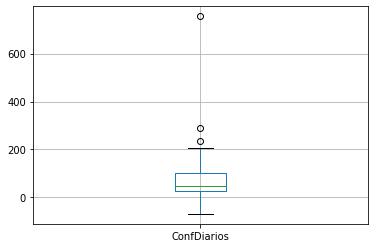

In [87]:
#@title Gráfico Outilier de Confirmação Diária
boxplot = dados.boxplot(column=['ConfDiarios'])

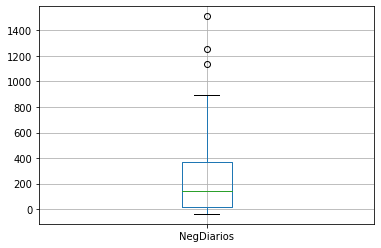

In [88]:
#@title Gráfico Outilier de Casos Negativos Diários
boxplot = dados.boxplot(column=['NegDiarios'])

#Excluindo linha

In [89]:
#@title Excluindo dias com diminuição de casos
c = 1
while True:
  if dados.loc[c, 'Confirmados'] < dados.loc[c-1, 'Confirmados']:
    for z in range(c-1, len(dados)-1):
      dados.loc[z] = dados.loc[z+1]
    dados.drop([len(dados)-1],inplace=True)  
     
  c +=1
  if c >= len(dados):
    break

#Acrescentando Coluna 
*Após retirada de possiveis erros 

In [90]:
#@title ID
dados.insert(loc = 0, column = 'ID', value =0)
for c in range (0, len(dados)):
  dados.loc[c,'ID']=c

#Gerando Projeção

In [91]:
#@title Preparação Coluna X e Y, e Cálculo para projeção
x = dados['ID']
y = dados['Confirmados']
cubica = np.poly1d(np.polyfit(x, y , 4))

In [92]:
#@title Erros da Projeção
#Erro médio
print ("Erro Médio é igual {:.2f}".format(erroMedio(y, cubica)))
#Erro médio quadratico
print("Erro médio quadratico é igual {:.2f}".format(erroMedioQuadratico(y, cubica)))
#Erro médio mediano
print("Erro mediano é igual {:.2f}".format(erroMedioMediano(y, cubica)))
#Erro do último dado
print("O erro de hoje, {}, foi de {:.0f} casos.".format(dados_originais.loc[len(dados)-1,'Data'],abs(cubica(len(x)-1)- y[len(dados)-1])))

Erro Médio é igual 93.91
Erro médio quadratico é igual 14860.74
Erro mediano é igual 83.00
O erro de hoje, 2020-07-22, foi de 40 casos.


In [93]:
#@title Previsões
print("Previsão para amanhã, {}, é de {} confirmados". format(dados.loc[len(dados)-1,'Data']+ timedelta(1),int(cubica(len(x)))))
for c in range (0,100):
  if cubica(len(x)+c) > 7500:
    print("Em + {} dias, ou seja {}, passaremos de 7500 casos confirmados".format(c+1, dados.loc[len(x)-1,'Data'] + timedelta(days = c+1)))
    break
for c in range (0,100):
  if cubica(len(x)+c) > 10000:
    print("Em + {} dias, ou seja {}, passaremos de 10000 casos confirmados".format(c+1,dados.loc[len(x)-1,'Data'] + timedelta(days = c+1)))
    break

Previsão para amanhã, 2020-07-24 00:00:00, é de 7309 confirmados
Em + 2 dias, ou seja 2020-07-25 00:00:00, passaremos de 7500 casos confirmados
Em + 11 dias, ou seja 2020-08-03 00:00:00, passaremos de 10000 casos confirmados


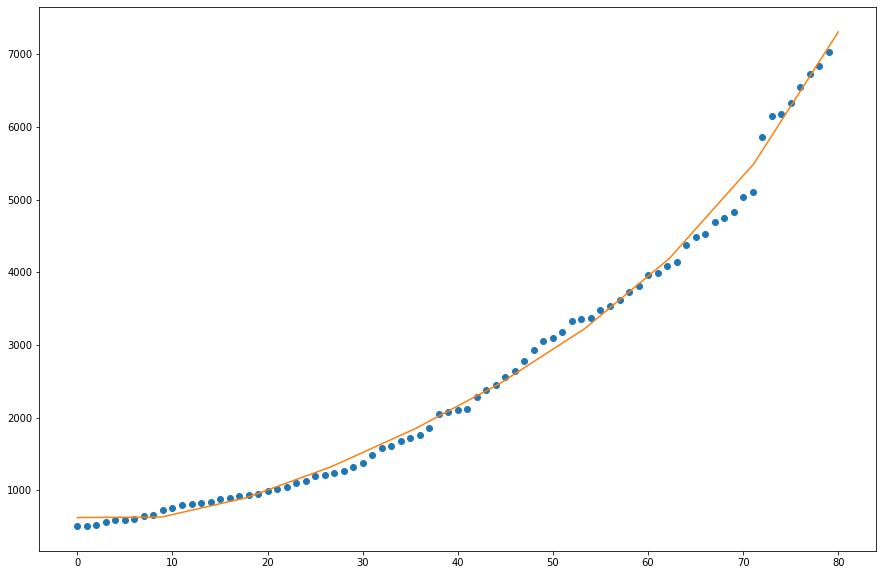

In [94]:
#@title Gráfico Projeção
tempoProjecao = 0 #@param {type:"slider", min:0, max:100, step:1}
t = np.linspace(0,len(x)+tempoProjecao,10)
plt.figure(figsize=(15,10))
grafico = plt.plot(x, y, 'o', t, cubica(t), '-')

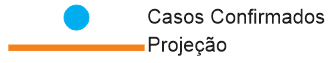

In [95]:
#@title Calculando Média Conf. Diários
#média de confirmados diários
mediaDiaria = []
somaConf = 7
for i in range(1,len(dados_originais)):
  somaConf += int(dados_originais.loc[i, 'Confirmados'] - dados_originais.loc[i-1, 'Confirmados'])
  mediaDiaria.append(float(somaConf/(i+1)))
print(somaConf)

6535


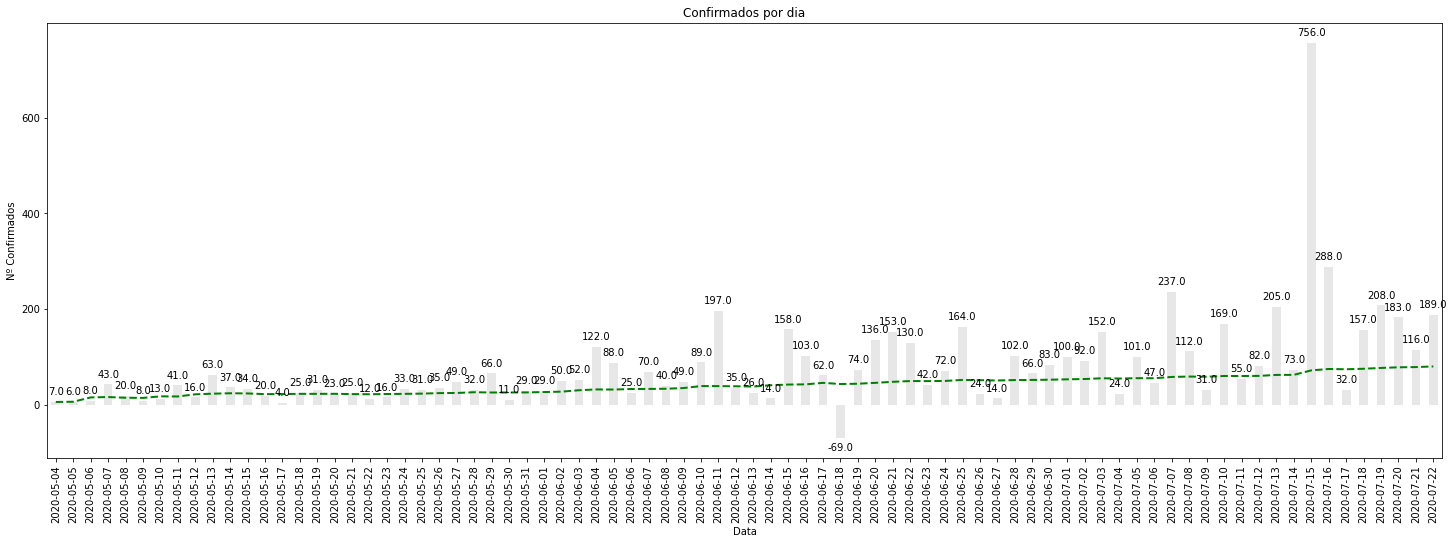

In [96]:
#@title Gráfico Crescimento pelo tempo

plt.figure(figsize=(25, 8),)
ax = dados['ConfDiarios'].plot(kind='bar',color=(0.1, 0.1, 0.1, 0.1))
ax2 = mediaDiaria

ax.set_title('Confirmados por dia')
ax.set_xlabel('Data')
ax.set_ylabel('Nº Confirmados')

plt.plot(ax2,'g--',linewidth=2)
x_labels =  dados_originais['Data'] 
ax.set_xticklabels(x_labels) #Mostrará a data inicial ao invés do ID
add_value_labels(ax)
plt.show()


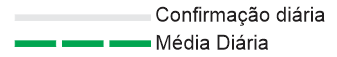

In [97]:
#@title Inserindo %Óbitos/Conf na tabela
dados.insert(loc = 11, column = '%Óbitos/Conf.', value =0)
for i in range(len(dados)):
  dados.loc[i, '%Óbitos/Conf.'] = (dados.loc[i, 'Obitos']/dados.loc[i, 'Confirmados'])*100

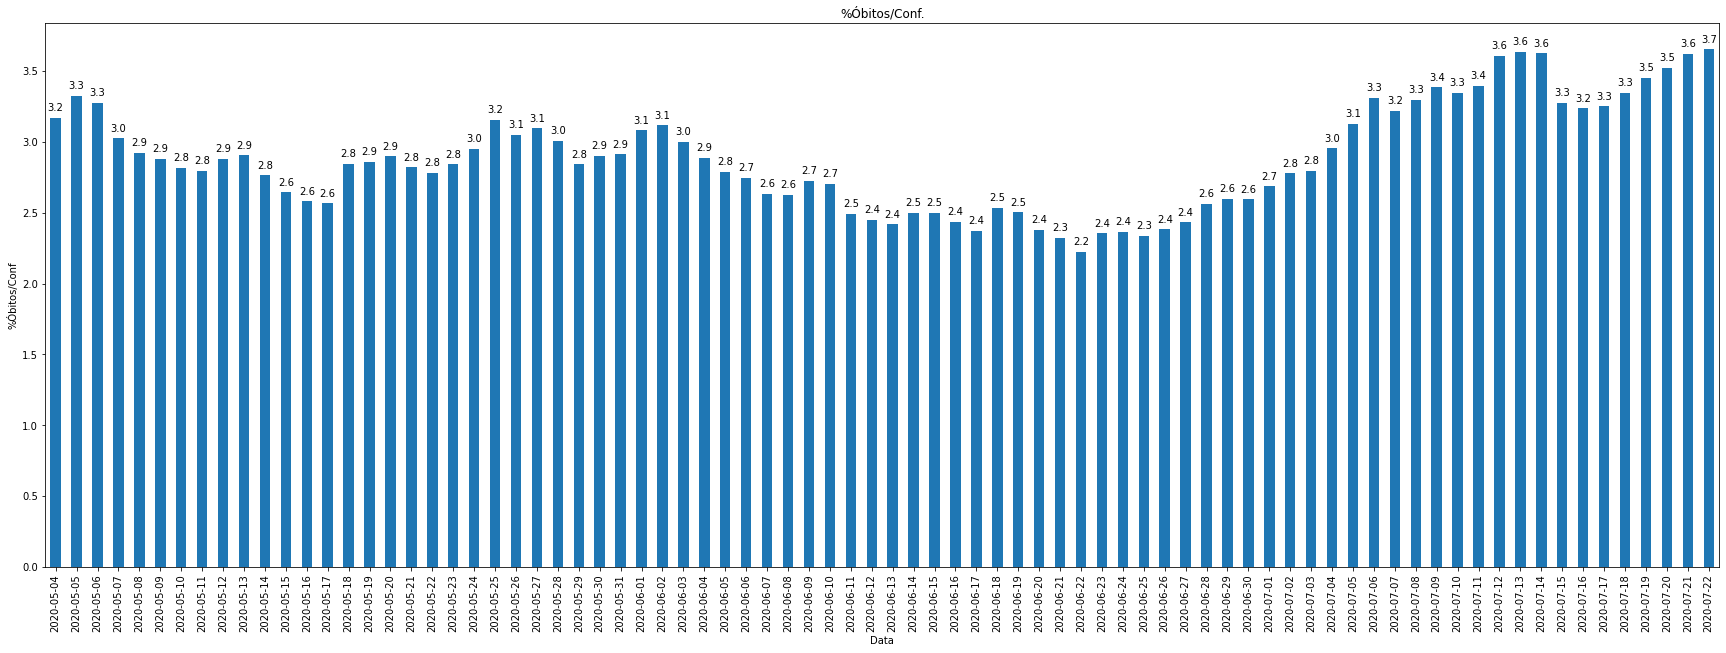

In [98]:
#@title %Óbitos/Conf x Data
plt.figure(figsize=(30, 10))
ax = dados['%Óbitos/Conf.'].plot(kind='bar')
ax.set_title('%Óbitos/Conf.')
ax.set_xlabel('Data')
ax.set_ylabel('%Óbitos/Conf')
x_labels =  dados_originais['Data'] 
ax.set_xticklabels(x_labels) #Mostrará a data inicial ao invés do ID
add_value_labels(ax)
plt.show()


In [99]:
#@title Tabela Final 
dados

,ID,Data,Confirmados,EmAnalise,Negativos,Obitos,Recuperados,inconclusivos,UTIConfirmado,ConfDiarios,NegDiarios,%Óbitos/Conf.
0,0,2020-05-04,505,402,1422,16,303,2,36,7,41,3.168317
1,1,2020-05-05,511,333,1452,17,327,2,30,6,30,3.326810
2,2,2020-05-06,519,281,1494,17,343,2,38,8,42,3.275530
3,3,2020-05-07,562,318,1553,17,367,2,39,43,59,3.024911
4,4,2020-05-08,582,361,1602,17,374,2,40,20,49,2.920962
...,...,...,...,...,...,...,...,...,...,...,...,...
75,75,2020-07-19,6337,9549,19598,212,3355,16,270,157,6,3.345432
76,76,2020-07-20,6545,11897,19592,226,3670,16,282,208,-6,3.453018
77,77,2020-07-21,6728,12477,20726,237,3701,17,281,183,1134,3.522592
78,78,2020-07-22,6844,13390,20729,248,3719,17,285,116,3,3.623612


#Semanal

In [ ]:
#@title Criando uma tabela vazia para receber os dados semanais
dadosSemanais = newEmptyCSV(dados[['ID']])

In [101]:
#@title Gerando os dados
#@markdown #####Data Inicia da semana
#@markdown #####Quantos exames foram realizados por Semana
#@markdown #####Confirmações Semanais
#@markdown #####Caos Negados por Semana
#@markdown #####% de exames realizados com resultado positivo
examesSemanal = []
confSemanal = []
negSemanal = []
semana = 0
somaConf = 0
somaNeg = 0
dataInicial = []
for c in range(6, len(dados), 7):
  dataInicial.insert(semana, dados_originais.loc[c-6,'Data']) 
  for z in range(c,c-7,-1):
    somaConf += dados.loc[z, 'ConfDiarios']
    somaNeg += dados.loc[z, 'NegDiarios']
  examesSemanal.insert(semana , somaConf + somaNeg)
  confSemanal.insert(semana, somaConf)
  negSemanal.insert(semana, somaNeg)
  semana +=1
  somaConf = 0
  somaNeg = 0

In [ ]:
#@title Acrescentado as colunas e os dados

dadosSemanais.insert(loc=0, column = 'ID', value =0)
dadosSemanais.insert(loc=1, column = 'Data Inicial', value =0)
dadosSemanais.insert(loc=2, column = 'Conf.Semanal', value =0)
dadosSemanais.insert(loc=3, column = 'Neg.Semanal', value =0)
dadosSemanais.insert(loc=4, column = 'ExamesRealizasdos', value =0)
dadosSemanais.insert(loc=5, column = 'Percentual.Conf', value =0)


for c in range(0, len(examesSemanal)):
  dadosSemanais.loc[c, "ID"] = c
  dadosSemanais.loc[c, "Data Inicial"] = dataInicial[c]
  dadosSemanais.loc[c, "ExamesRealizasdos"] = examesSemanal[c]
  dadosSemanais.loc[c, "Neg.Semanal"] = negSemanal[c]
  dadosSemanais.loc[c, "Conf.Semanal"] = confSemanal[c]
  dadosSemanais.loc[c, "Percentual.Conf"] = (dadosSemanais.loc[c, "Conf.Semanal"] / dadosSemanais.loc[c, "ExamesRealizasdos"])*100

In [103]:
#@title Tabela Gerada
dadosSemanais

,ID,Data Inicial,Conf.Semanal,Neg.Semanal,ExamesRealizasdos,Percentual.Conf
0,0.0,2020-05-04,105.0,250.0,355.0,29.577465
1,1.0,2020-05-11,215.0,571.0,786.0,27.353690
2,2.0,2020-05-18,165.0,535.0,700.0,23.571429
3,3.0,2020-05-25,253.0,594.0,847.0,29.870130
4,4.0,2020-06-01,436.0,796.0,1232.0,35.389610
5,5.0,2020-06-08,450.0,2694.0,3144.0,14.312977
6,6.0,2020-06-15,617.0,2093.0,2710.0,22.767528
7,7.0,2020-06-22,548.0,2759.0,3307.0,16.570910
8,8.0,2020-06-29,618.0,2287.0,2905.0,21.273666
9,9.0,2020-07-06,733.0,3578.0,4311.0,17.003016


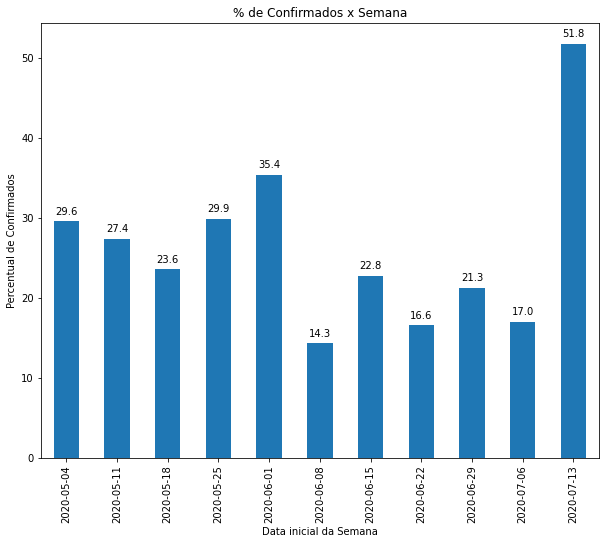

In [104]:
#@title Gráfico % Exames com casos Confirmados

plt.figure(figsize=(10, 8))
ax = dadosSemanais['Percentual.Conf'].plot(kind='bar')
ax.set_title('% de Confirmados x Semana')
ax.set_xlabel('Data inicial da Semana')
ax.set_ylabel('Percentual de Confirmados')
x_labels =  dadosSemanais['Data Inicial'] 
ax.set_xticklabels(x_labels) #Mostrará a data inicial ao invés do ID
add_value_labels(ax)
plt.show()

#Consulta de Dados
* Link dos arquivos diários da Prefeitura de Porto Alegre

In [105]:
#@title Datas com documentos disponiveis
print("O primeiro arquivo PDF disponibilizado pela Prefeitura é da data de {}". format("2020-04-10"))
print("O primeiro arquivo PDF utilizado para essa análise é de {}". format(dados_originais.loc[0,"Data"]))
print("O último arquivo PDF utilizado para essa análise é de {}".format(dados_originais.loc[len(dados_originais)-1,"Data"]))

O primeiro arquivo PDF disponibilizado pela Prefeitura é da data de 2020-04-10
O primeiro arquivo PDF utilizado para essa análise é de 2020-05-04
O último arquivo PDF utilizado para essa análise é de 2020-07-23


In [106]:
#@title Data para obter Link do Documento
Data  = '2020-07-22' #@param {type:"date"}
dia = Data[-2] + Data[-1]
mes = Data[5] + Data[6]
dataDados= "2020-" +mes+"-" +dia
 
 
arquivo = 0
for c in range (len(dados_originais)):
  if dados_originais.loc[c,"Data"] == dataDados:
    arquivo = c + 43
    break
if arquivo == 0:
  dataDocumento = ["2020-04-10","2020-04-11","2020-04-12","2020-04-13",
"2020-04-14","2020-04-15","2020-04-16","2020-04-17","2020-04-18",
"2020-04-19","2020-04-20","2020-04-21","2020-04-22","2020-04-23",
"2020-04-24","2020-04-25","2020-04-26","2020-04-27","2020-04-28",
"2020-04-29","2020-04-30","2020-05-01","2020-05-02","2020-05-03"]
  for c in range(len(dataDocumento)):
    if dataDocumento[c] == dataDados:
      arquivo = 19 + c
      break
 
 
 
if arquivo == 0:
  print("Data não encontrada")
else:
  if arquivo < 43:
    print("Este documento não foi utilizado para essa análise")
  print("Link: " + "http://lproweb.procempa.com.br/pmpa/prefpoa/sms/usu_doc/2020_{}_{}_boletim_covid_sms_{}.pdf".format(mes,dia,arquivo))

Link: http://lproweb.procempa.com.br/pmpa/prefpoa/sms/usu_doc/2020_07_22_boletim_covid_sms_122.pdf
